<h1>Import Libraries</h1>

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

<h1>Data Preparation</h1>

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2025-12-27 15:31:58--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2025-12-27 15:31:59--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M   398KB/s    in 7m 6s   

2025-12-27 15:39:05 (478 KB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [ ]:
!unzip Audio_Speech_Actors_01-24.zip

Archive:  Audio_Speech_Actors_01-24.zip
   creating: Actor_01/
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03-01-02-02-01.wav  
  inflating: Actor_01/03-01-03-02-01-01-01.wav  
  inflating: Actor_01/03-01-03-02-01-02-01.wav  
  inflating: Actor_01/03-01-03-02-02-01-01.wav  
  infl

In [ ]:
import os
os.listdir("/content")

['.config',
 'Actor_16',
 'Actor_03',
 'Actor_22',
 'Actor_14',
 'Actor_20',
 'Actor_02',
 'Actor_05',
 'Actor_10',
 'Actor_19',
 'Audio_Speech_Actors_01-24.zip',
 'Actor_08',
 'drive',
 'Actor_18',
 'Actor_07',
 'Actor_23',
 'Actor_17',
 'Actor_01',
 'Actor_13',
 'Actor_11',
 'Actor_21',
 'Actor_15',
 'Actor_12',
 'Actor_04',
 'Actor_06',
 'Actor_24',
 'Actor_09',
 'sample_data']

In [ ]:
Ravdess = "/content/"

<h1>Ravdess Dataframe</h1>

In [ ]:
import os
import pandas as pd

Ravdess = "/content/"

# ONLY actor folders
ravdess_directory_list = [
    d for d in os.listdir(Ravdess)
    if d.startswith("Actor_")
]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_path = os.path.join(Ravdess, dir)

    for file in os.listdir(actor_path):
        # ONLY wav files
        if not file.endswith(".wav"):
            continue

        part = file.split('.')[0].split('-')

        # RAVDESS files MUST have 7 parts
        if len(part) < 3:
            continue

        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(actor_path, file))

# Create DataFrame
Ravdess_df = pd.DataFrame({
    "Emotions": file_emotion,
    "Path": file_path
})

# Map emotion labels
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].replace({
    1:'neutral', 2:'calm', 3:'happy', 4:'sad',
    5:'angry', 6:'fear', 7:'disgust', 8:'surprise'
})

Ravdess_df.head()

Emotions                                        Path
0      fear  /content/Actor_16/03-01-06-01-02-01-16.wav
1      fear  /content/Actor_16/03-01-06-01-02-02-16.wav
2   disgust  /content/Actor_16/03-01-07-01-01-01-16.wav
3  surprise  /content/Actor_16/03-01-08-02-01-01-16.wav
4      calm  /content/Actor_16/03-01-02-02-02-02-16.wav

In [ ]:
# creating Dataframe.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                        Path
0      fear  /content/Actor_16/03-01-06-01-02-01-16.wav
1      fear  /content/Actor_16/03-01-06-01-02-02-16.wav
2   disgust  /content/Actor_16/03-01-07-01-01-01-16.wav
3  surprise  /content/Actor_16/03-01-08-02-01-01-16.wav
4      calm  /content/Actor_16/03-01-02-02-02-02-16.wav

<h1>Data Visualisation and Exploration</h1>

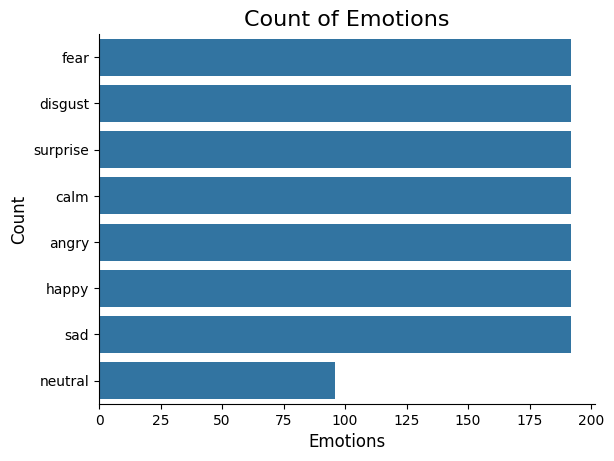

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    # librosa.display.waveplot(data, sr=sr)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

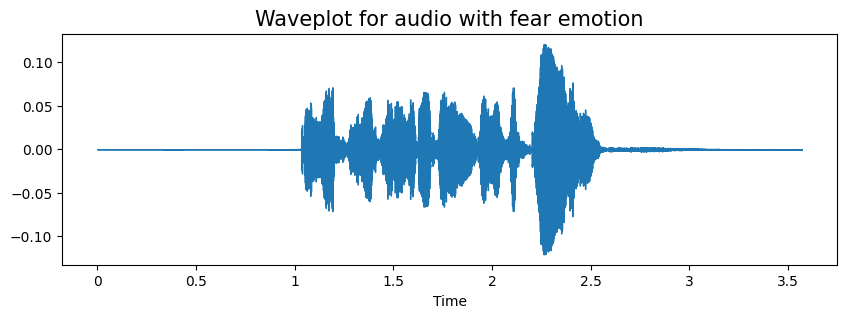

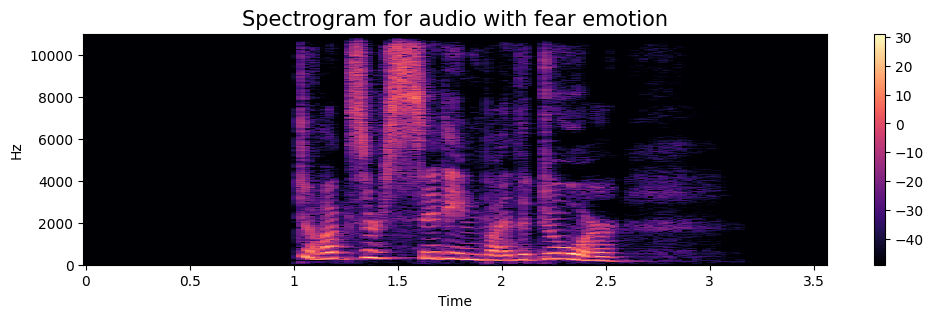

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

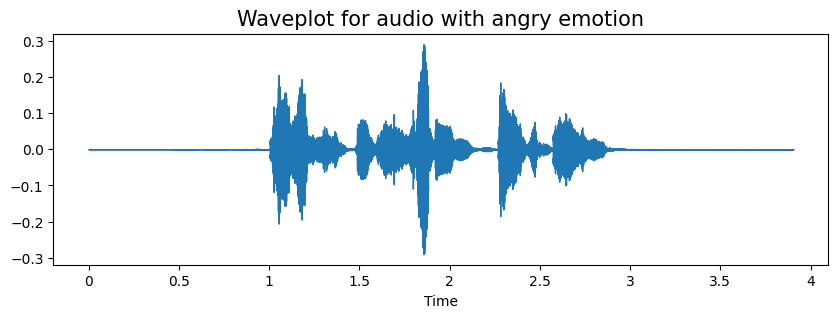

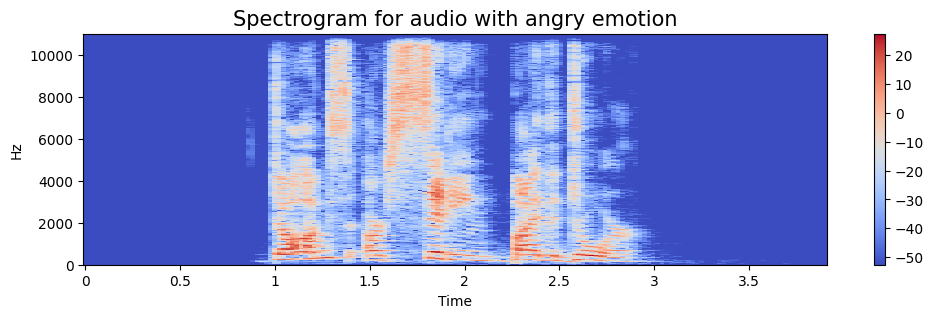

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

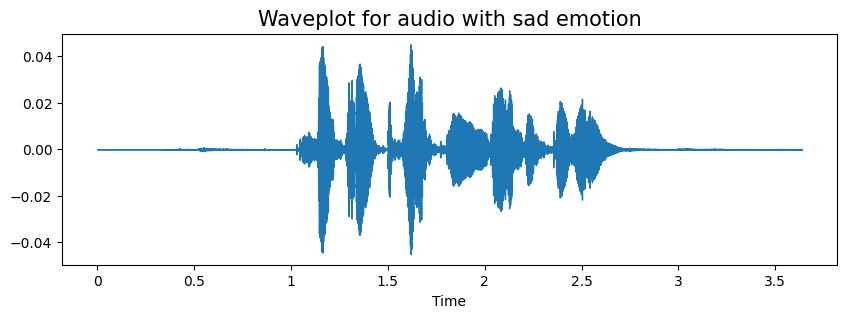

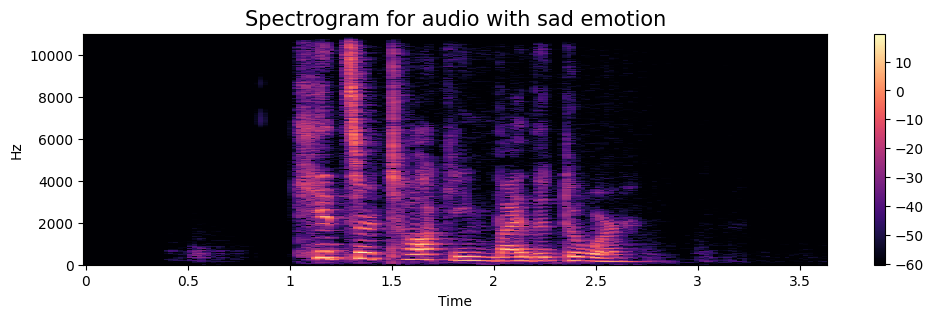

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

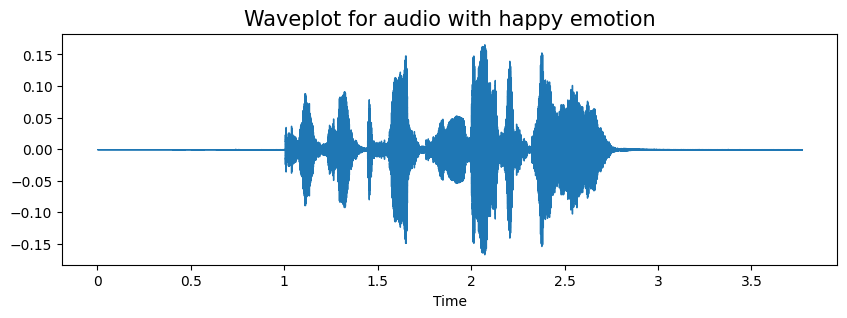

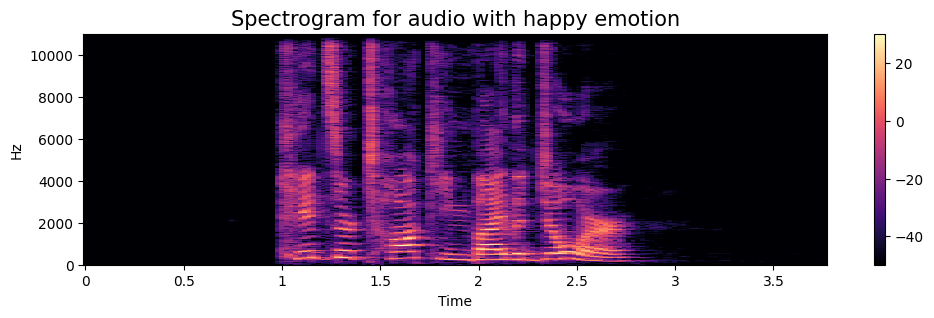

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

<h1>Data Augmentation</h1>

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

<h3>1. Simple Audio</h3>

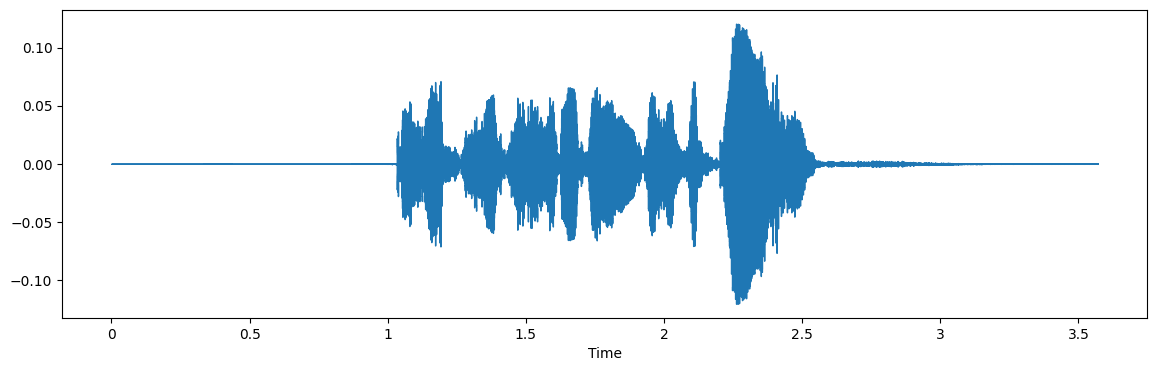

In [ ]:
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=data, sr=sample_rate)
librosa.display.waveshow(data, sr=sample_rate)
Audio(path)

<h3>2. Noise Injection</h3>

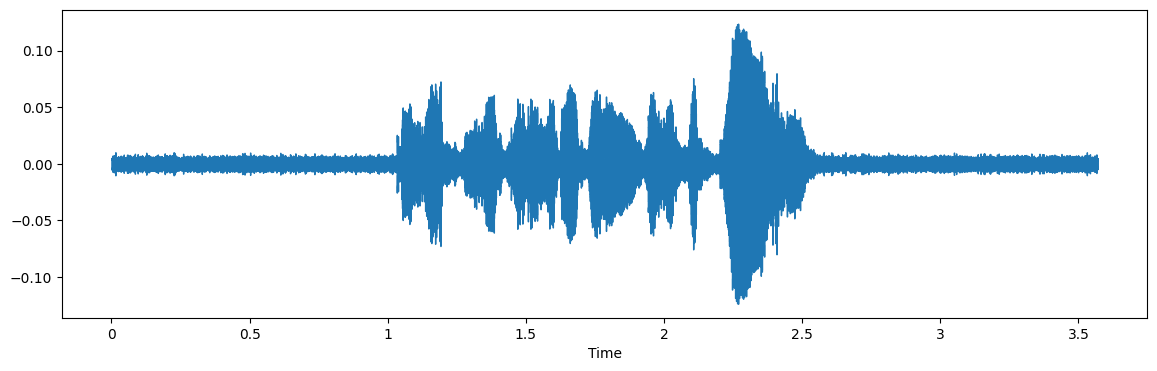

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
librosa.display.waveshow(x, sr=sample_rate)
Audio(x, rate=sample_rate)

<h3>Stretching</h3>

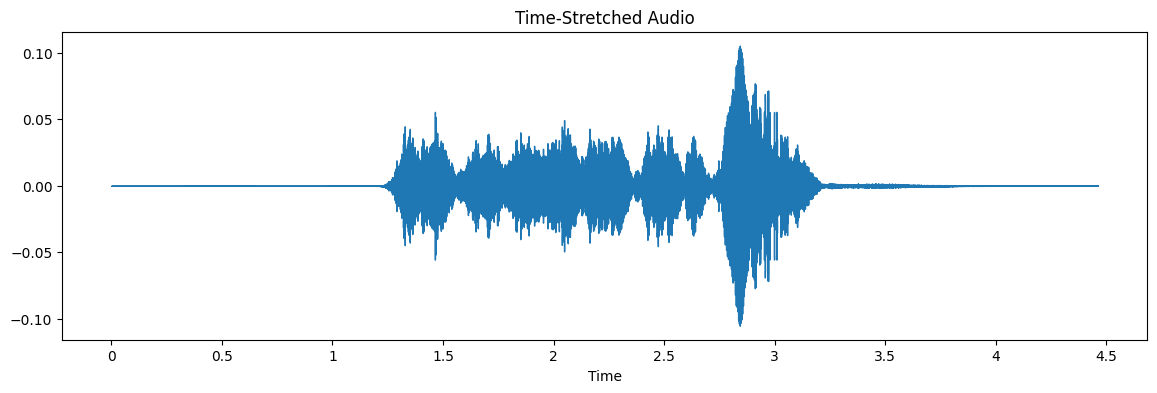

In [ ]:
# x = stretch(data)
# plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

path = np.array(Ravdess_df.Path)[1]  # use your correct dataframe
data, sample_rate = librosa.load(path)

# Apply time-stretch
x = stretch(data, rate=0.8)

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Time-Stretched Audio")
plt.show()

# Play audio
Audio(x, rate=sample_rate)

<h3>4. Shifting</h3>

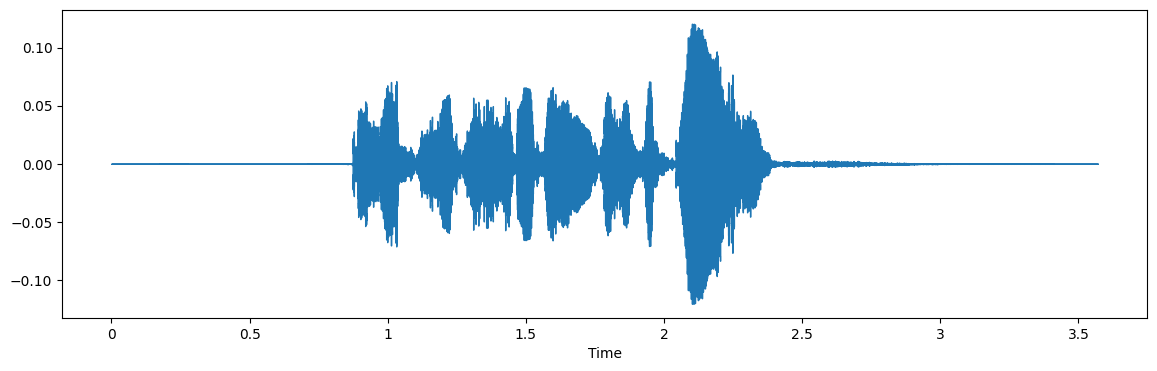

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
librosa.display.waveshow(x, sr=sample_rate)
Audio(x, rate=sample_rate)

<h3>5. Pitch</h3>

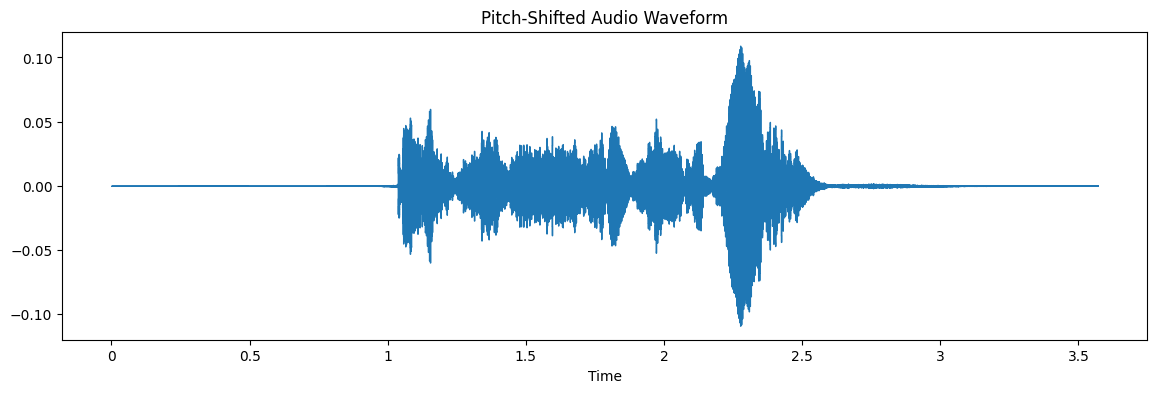

In [ ]:
# x = pitch(data, sample_rate)
# plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
# Audio(x, rate=sample_rate)

x = pitch(data, sample_rate, pitch_factor=0.7)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Pitch-Shifted Audio Waveform")
plt.show()

Audio(x, rate=sample_rate)

<h1>Feature Extraction</h1>

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.308372  0.726484  0.629364  0.593539  0.593567  0.559343  0.478002   
1  0.335947  0.745974  0.699341  0.691965  0.714277  0.689716  0.601461   
2  0.195866  0.760369  0.677780  0.586663  0.586644  0.570372  0.474866   
3  0.189815  0.559443  0.520537  0.485576  0.441410  0.396067  0.403144   
4  0.283574  0.706120  0.701556  0.685792  0.666832  0.618919  0.583438   

          7         8         9  ...       153       154       155       156  \
0  0.525374  0.546580  0.573754  ...  0.003140  0.002693  0.000874  0.001335   
1  0.619540  0.609854  0.656179  ...  0.004050  0.003389  0.001571  0.002044   
2  0.475975  0.541759  0.499483  ...  0.001072  0.000667  0.000613  0.000394   
3  0.412471  0.440801  0.506294  ...  0.002601  0.002952  0.003851  0.003154   
4  0.542990  0.553813  0.583126  ...  0.002662  0.003017  0.003904  0.003209   

        157       158       159       160       161  labels  
0  0.001741  0.001882  0.001540  0.001250  0.000133    fear  
1  0.002480  0.002660  0.002357  0.001998  0.000846    fear  
2  0.000155  0.000277  0.000330  0.000198  0.000010    fear  
3  0.002964  0.002586  0.002761  0.001653  0.000115    fear  
4  0.003016  0.002648  0.002831  0.001708  0.000169    fear  

[5 rows x 163 columns]

<h1>Data Preparation<h1>

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

<h1>Modelling<h1>

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.1703 - loss: 2.0234 - val_accuracy: 0.2315 - val_loss: 1.9395 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2264 - loss: 1.9409 - val_accuracy: 0.2472 - val_loss: 1.8656 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2378 - loss: 1.9042 - val_accuracy: 0.3315 - val_loss: 1.8382 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2535 - loss: 1.8590 - val_accuracy: 0.3185 - val_loss: 1.7673 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2914 - loss: 1.8005 - val_accuracy: 0.2870 - val_loss: 1.7825 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3109 - loss: 1.7590 - val_accuracy: 0.3667 - val_loss: 1.7081 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3620 - loss: 1.6851 - val_accurac

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6647 - loss: 1.2692
Accuracy of our model on test data :  66.0185158252716 %


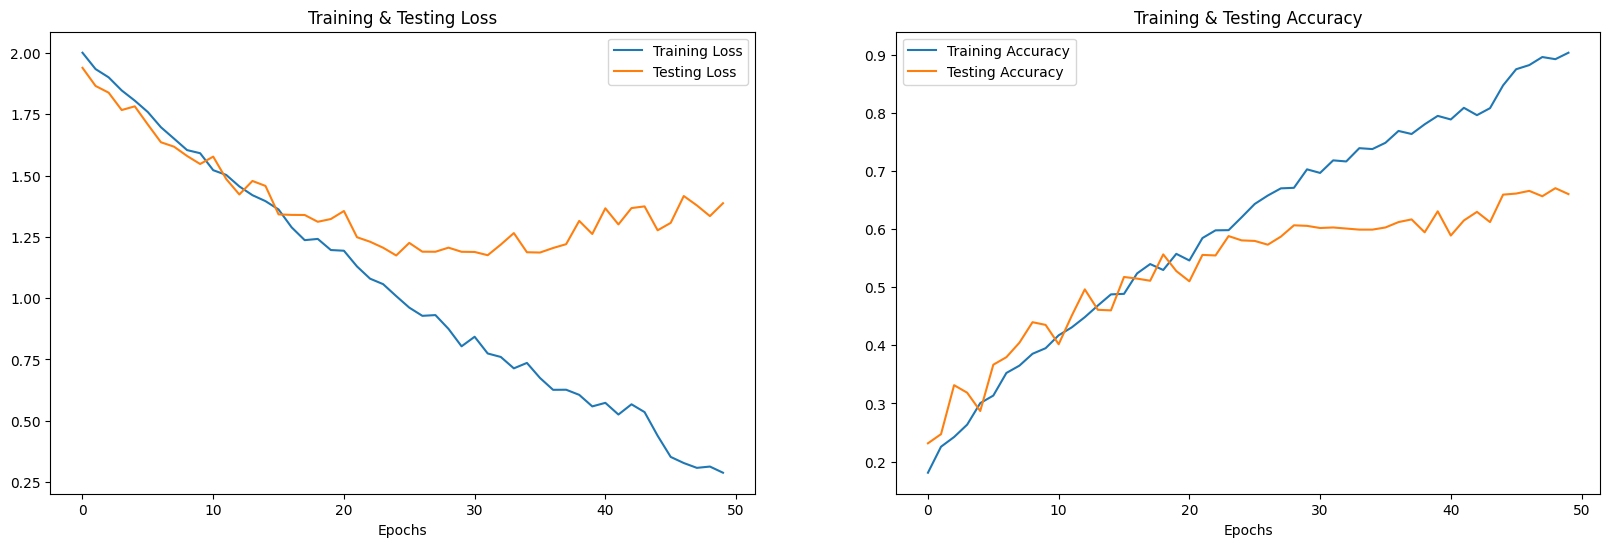

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad           sad
1          neutral       neutral
2             calm          calm
3            happy         happy
4             fear         happy
5          disgust       disgust
6          neutral       neutral
7            happy         happy
8            happy       disgust
9             calm          calm

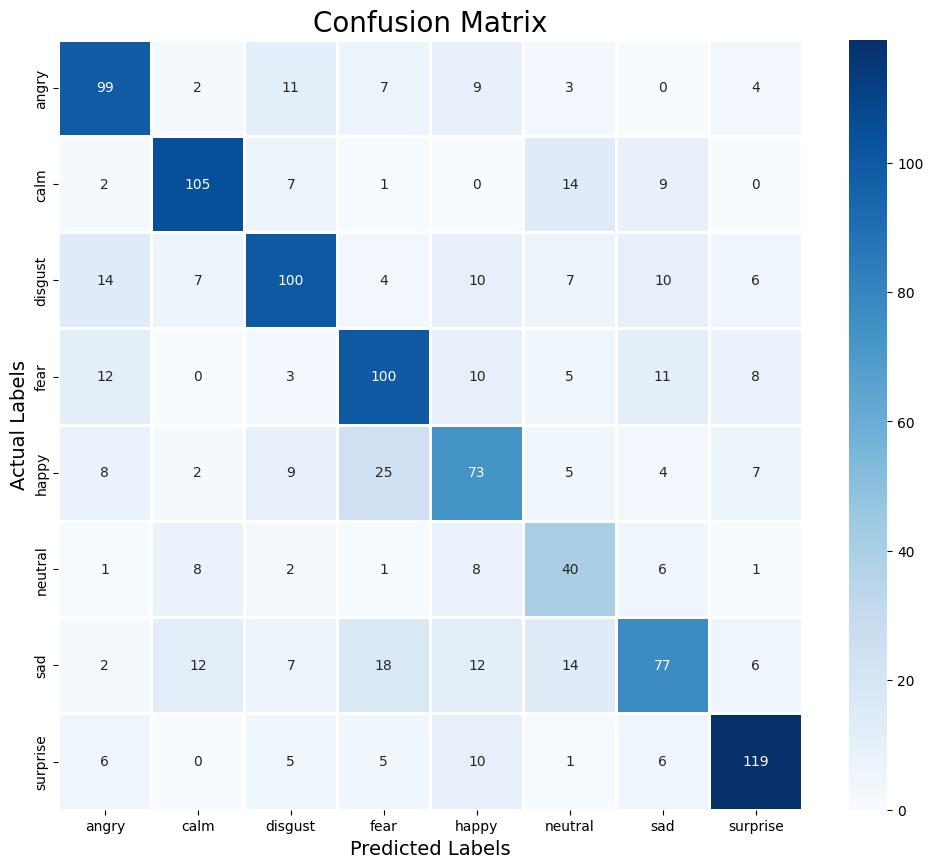

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.69      0.73      0.71       135
        calm       0.77      0.76      0.77       138
     disgust       0.69      0.63      0.66       158
        fear       0.62      0.67      0.65       149
       happy       0.55      0.55      0.55       133
     neutral       0.45      0.60      0.51        67
         sad       0.63      0.52      0.57       148
    surprise       0.79      0.78      0.79       152

    accuracy                           0.66      1080
   macro avg       0.65      0.66      0.65      1080
weighted avg       0.66      0.66      0.66      1080



In [ ]:
model.save("speech_emotion_cnn_model.h5")